# Simple Lane-Finding Algorithm


## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline


## Create Debug Environment

In [2]:
import logging
import sys #for debugging
import time

logger = logging.getLogger('laner finder')
logger.addHandler(logging.StreamHandler())
logger.setLevel(logging.WARNING) #use logging.DEBUG to turn on Debugging


In [3]:
print(F"Logger level set to: {logger.getEffectiveLevel()}")
logger.critical("Critical Level 50")
logger.error("Error Level 40")
logger.warning("Warning Level 30")
logger.info("Info Level 20")
logger.debug("Debug Level 10")


Critical Level 50
Error Level 40
Warning Level 30


Logger level set to: 30


## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (1076, 1918, 3)


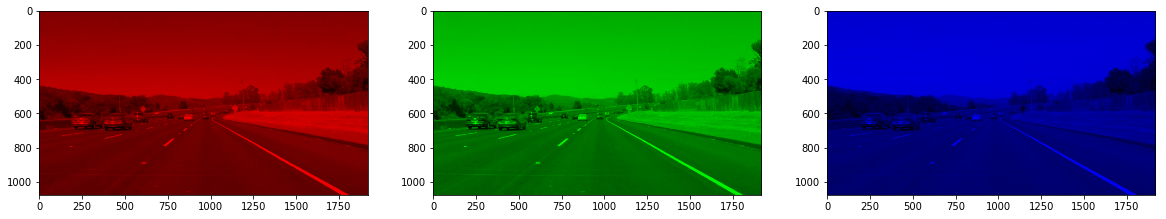

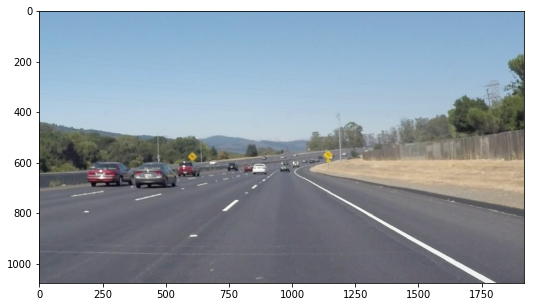

In [4]:
#reading in an image
image = cv2.imread('test_images/issue3.png')
image = cv2.cvtColor(image,cv2.COLOR_BGRA2RGB)
plt.rcParams["figure.figsize"] = (20,5)
#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
figure, plots = plt.subplots(ncols=3, nrows=1)
for i,subplot in zip(range(3), plots):
    tmp = np.zeros_like(image, dtype='uint8')
    tmp[:,:,i]=image[:,:,i]
    subplot.imshow(tmp)

plt.show()  # if you wanted to show a single color channel image called 'gray', 
plt.imshow(image)
#for example, call as plt.imshow(gray, cmap='gray')

# Create a work flow

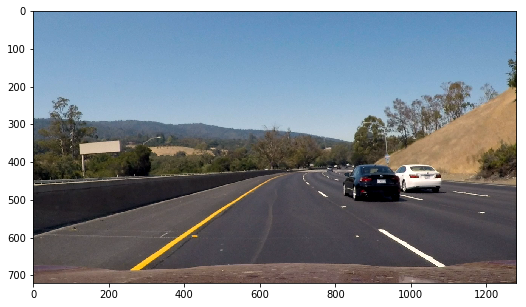

In [5]:
def step0_openFile(file):
    """
    Args: 
        file: path to file
    Returns:
        image as np array
    """
    image = cv2.imread(file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    return image
image = step0_openFile('test_images/issue6.png')

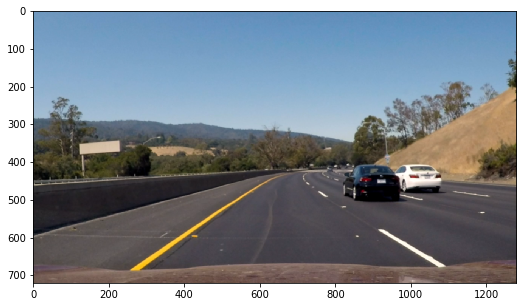

In [6]:
def step1_Blur(image):
    """
    Args:
        image: np array of image
    Returns:
        blured version of image as np array
    """
    kernel=5
    iblur = cv2.GaussianBlur(image,(kernel,kernel),0)
    plt.imshow(iblur)
    return iblur
iblur = step1_Blur(image);

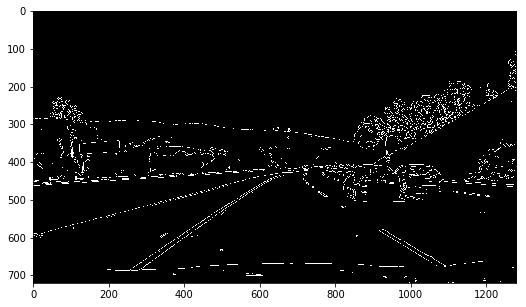

In [7]:
def step2_canny(iblur):
    """
    Args:
        iblur: blurred version of image as np array
    Returns:
        canny edge version of iblur
    """
    low_threshold = 80
    high_threshold = 120
    edges = cv2.Canny(iblur, low_threshold, high_threshold)
    plt.imshow(edges, cmap="gray")
    return edges
edges = step2_canny(iblur);

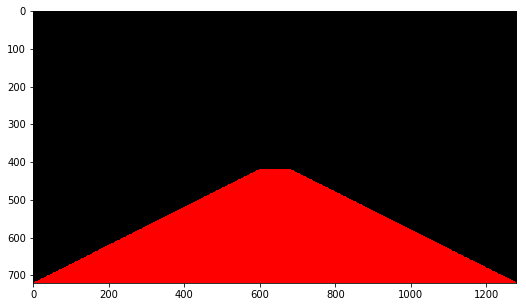

In [8]:
def step3_create_mask(image):
    """
    Args:
        image: image to mask
    Returns:
        mask: mask
    """
    mask = np.zeros_like(image)
    imshape=image.shape
    xsize = imshape[1]
    ysize = imshape[0]
    vertices = np.array([[(0,ysize),(int(0.5*xsize-0.03*xsize),int( 0.5*ysize+0.08*ysize)), \
                          (int(0.5*xsize+0.03*xsize),int( 0.5*ysize+0.08*ysize)), \
                          (xsize, ysize)]], dtype=np.int32)
    cv2.fillPoly(mask,vertices,255)
    plt.imshow(mask)
    return mask
mask = step3_create_mask(image)

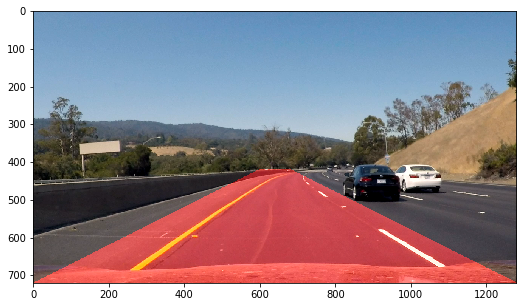

In [9]:
plt.imshow(cv2.addWeighted(image,1,mask,0.5,0))

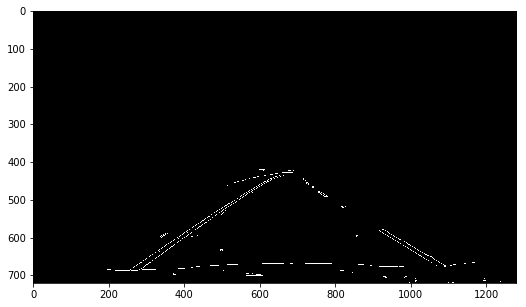

In [10]:
def step4_masked_ara(mask,edges):
    """
    Args:
        mask: mask to use
        edges: edge file to use
    Returns:
        masked_area
    """
    mask = cv2.cvtColor(mask,cv2.COLOR_RGBA2GRAY)
    masked_area = cv2.bitwise_and(mask,edges)
    plt.imshow(masked_area, cmap='gray')
    return masked_area
masked_area = step4_masked_ara(mask,edges);

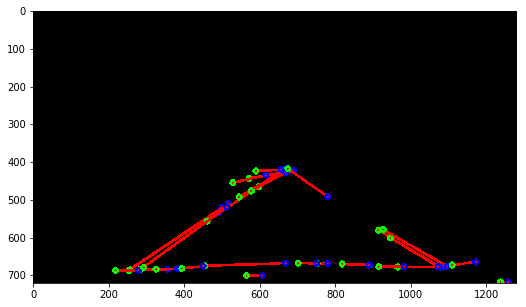

In [11]:
def step5_houghlines(masked_area, image):
    """
    Args:
        masked_area
    Returns:
        line_image: image with all lines drawn into it
        fits: array with all linear fits of all lines
    """
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 40     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 15 #minimum number of pixels making up a line
    max_line_gap =30    # maximum gap in pixels between connectable line segments
    line_image = np.copy(image)*0 # creating a blank to draw lines on

    lines = cv2.HoughLinesP(masked_area, rho, theta, threshold, np.array([]),
                                min_line_length, max_line_gap)
    fits = []
    radius = int(image.shape[1]*0.005)
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),radius)
            cv2.circle(line_image,(x1,y1),radius,(0,255,0),radius)
            cv2.circle(line_image,(x2,y2),radius,(0,0,255),radius)
            fits.append(np.polyfit([x1,x2],[y1,y2],1))
    plt.imshow(line_image)
    return line_image, fits
line_image, fits = step5_houghlines(masked_area, image);

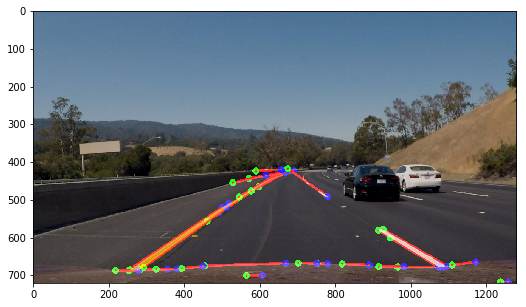

In [12]:
lines_edges = cv2.addWeighted(image, 0.8, line_image, 1, 0)
plt.imshow(lines_edges)

In [13]:
#https://stackoverflow.com/questions/16615662/how-to-write-text-on-a-image-in-windows-using-python-opencv2
def putLaneInformation(image, left_lanes, right_lanes):
    imshape=image.shape
    xsize = imshape[1]
    ysize = imshape[0]
    
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    ll_position            = (10,int(0.1*ysize))
    rl_position            = (10,int(0.1*ysize) + 40)
    fontScale              = 1
    fontColor              = (255,255,255)
    lineType               = 2

    cv2.putText(image,F'Left Lane:{round(np.average(left_lanes[0]),3):>10} *X + {round(np.average(left_lanes[1]),3):>2}', 
        ll_position, 
        font, 
        fontScale,
        fontColor,
        lineType)
    
    cv2.putText(image,F'Right Lane:{round(np.average(right_lanes[0]),3):>10} *X + {round(np.average(right_lanes[1]),3):>2}', 
        rl_position, 
        font, 
        fontScale,
        fontColor,
        lineType)


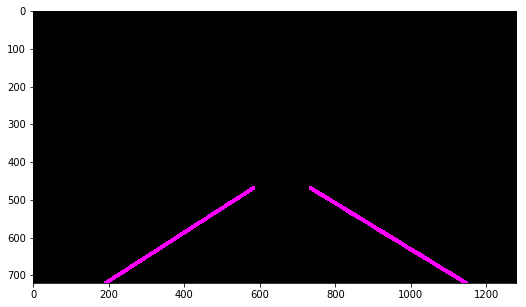

In [14]:
import inspect
left_lanes = list([[],[]])
right_lanes = list([[],[]])
def step6_interpolate_lanes(fits,  image, line_image, left_lanes, right_lanes):
    """
    Args:
        fits: np array with all fits for all possible lines to describe a lane
    Returns:
        interpolated_lanes: np image with all interpolated lanes drawn into it
    """
    buffer_size = 100
    logger.debug(f"...left_lane reference count: {sys.getrefcount(left_lanes)-1} with id: {id(left_lanes)}" )
    logger.debug(F"len fits:{len(fits)}")
    logger.debug(F"len left_lanes:{len(left_lanes[0])}")
    logger.debug(F"len right_lanes:{len(right_lanes[0])}")
    interpolated_lanes = np.copy(image)*0

    right_lane_detected = False
    left_lane_detected = False

    imshape=image.shape
    xsize = imshape[1]
    ysize = imshape[0]
    
    for i in fits:
        slope = i[0]
        bias = i[1]

        if np.abs(slope)>0.4 and np.abs(slope)<0.85: #Remove noise
            if slope < 0:
                left_lanes[0].append(slope)
                left_lanes[1].append(bias)
            else:
                right_lanes[0].append(slope)
                right_lanes[1].append(bias)

    if len(left_lanes[0]):
        left_lane_detected = True
    if len(right_lanes[0]):
        right_lane_detected = True
    
    left_lanes[0][:]=left_lanes[0][-buffer_size:] #negative slope
    left_lanes[1][:]=left_lanes[1][-buffer_size:] #negative bias
    right_lanes[0][:]=right_lanes[0][-buffer_size:] #positive slope
    right_lanes[1][:]=right_lanes[1][-buffer_size:] #positive bias
    def returns_int(func):
        logger.debug(F"returns_int called by {inspect.stack()[1].function}")
        def wrapper(XY):
            logger.debug(F"wrapper called by {inspect.stack()[1].function}")
            return int(func(XY))
        return wrapper
    
    @returns_int
    def left_lane_X(X):
        return np.average(left_lanes[0])* X+ np.average(left_lanes[1])
    @returns_int
    def right_lane_X(X):
        return np.average(right_lanes[0])*X + np.average(right_lanes[1]) 
    @returns_int
    def left_lane_Y(Y):
        return (Y - np.average(left_lanes[1])) / np.average(left_lanes[0])
    @returns_int
    def right_lane_Y(Y):
        return (Y-np.average(right_lanes[1]) )/np.average(right_lanes[0])
    
    if(right_lane_detected):
        cv2.line(interpolated_lanes,(right_lane_Y(int(0.65*ysize)),int(0.65*ysize)),(right_lane_Y(ysize),ysize),(255,0,255),10)
    if(left_lane_detected):
        cv2.line(interpolated_lanes,(left_lane_Y(int(0.65*ysize)),int(0.65*ysize)),(left_lane_Y(ysize),ysize),(255,0,255),10)
    

    if(logger.getEffectiveLevel() < 20): #If level is set to debug then add lines and points
        logger.debug('Adding points and lines to the image')
        interpolated_lanes = cv2.addWeighted(interpolated_lanes, 1, line_image, 0.7, 0)
        putLaneInformation(interpolated_lanes, left_lanes, right_lanes)
    plt.imshow(interpolated_lanes)
    
    return interpolated_lanes
interpolated_lanes = step6_interpolate_lanes(fits, image, line_image, left_lanes, right_lanes);

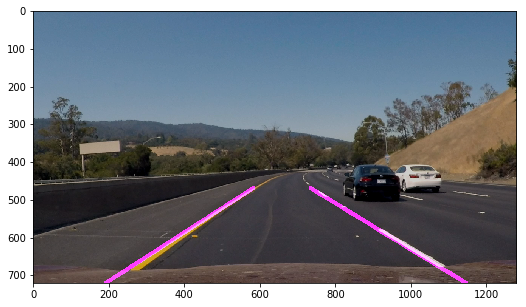

In [15]:
def step7_merge(image,interpolated_lanes):
    """
    Args:
        image: original image
        interpolated_lanes: np image with interpolated lanes
    Returns:
        lines_edges: merge of interpolated lanes and the original image
    """
    lines_edges = cv2.addWeighted(image, 0.8, interpolated_lanes, 1, 0)
    plt.imshow(lines_edges)
    return lines_edges
step7_merge(image,interpolated_lanes);

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [16]:
import os
root = "test_images"
files = os.listdir(root)
os.listdir(root)

['1551612544.992068.png',
 '1551612545.037023.png',
 'issue1.png',
 'issue2.png',
 'issue3.png',
 'issue4.png',
 'issue5.png',
 'issue6.png',
 'solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

In [17]:
!rm test_images/.DS_Store

rm: test_images/.DS_Store: No such file or directory


## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

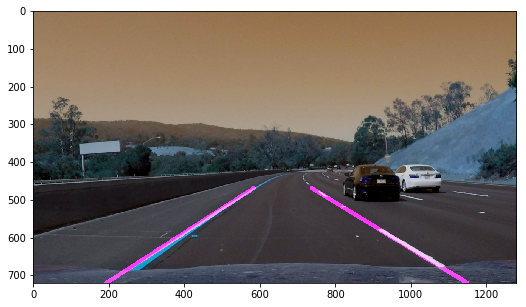

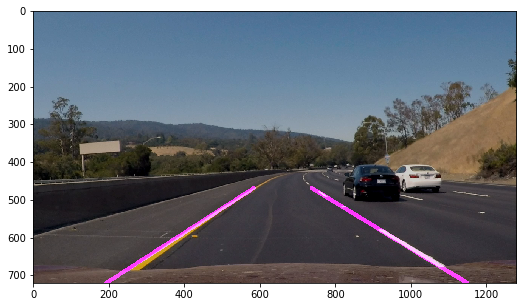

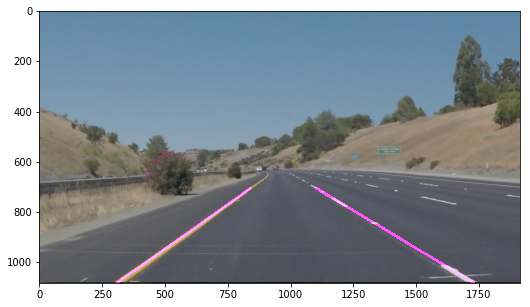

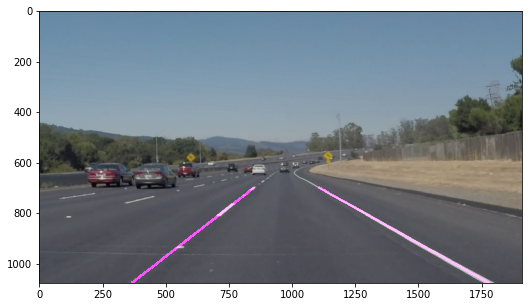

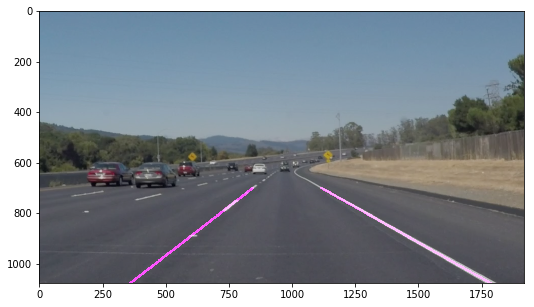

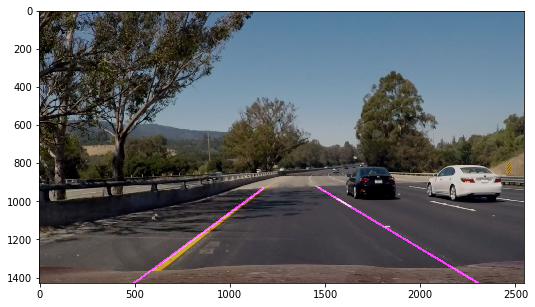

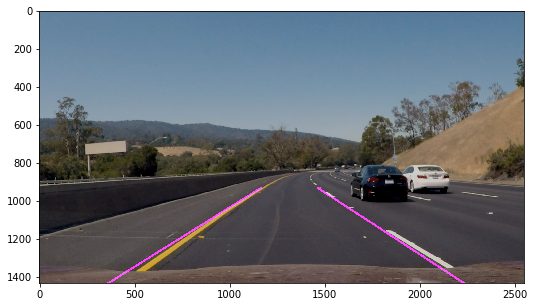

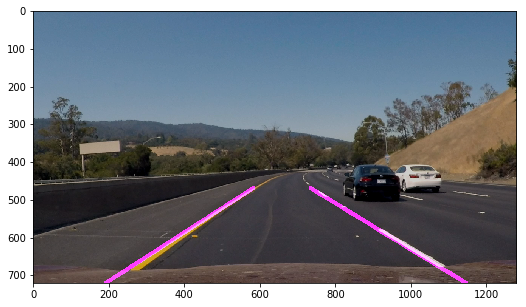

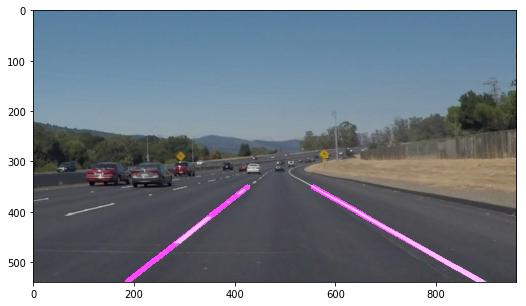

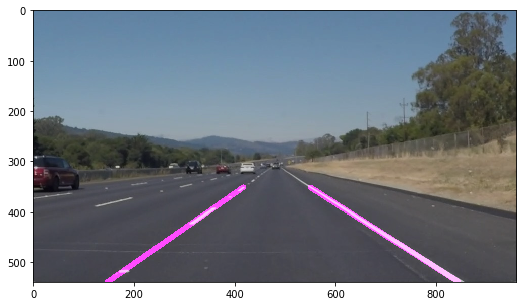

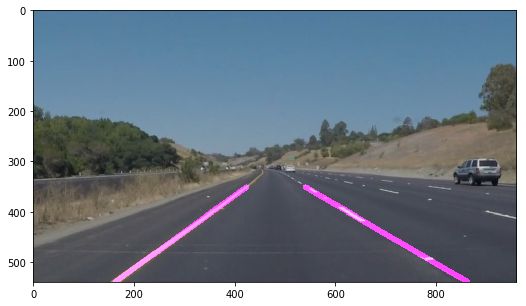

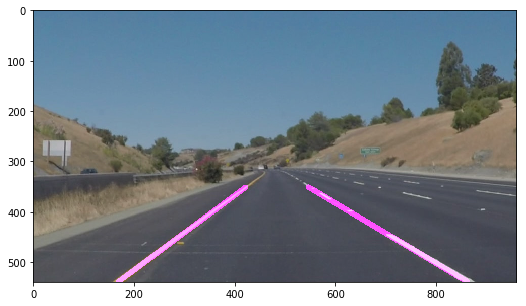

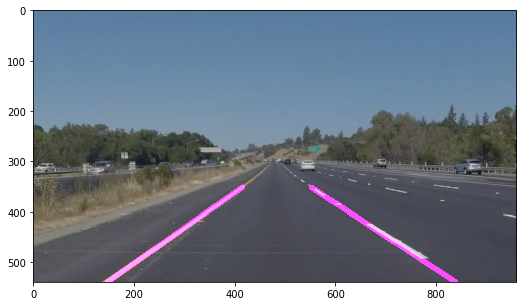

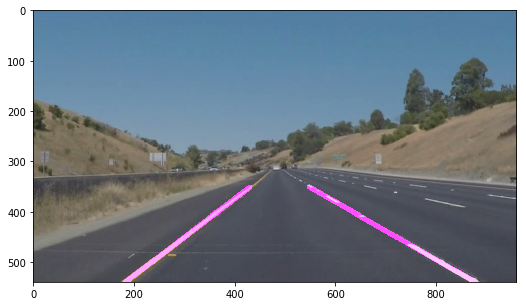

In [18]:
def pipeline(file):
    left_lanes = [[],[]]
    right_lanes = [[],[]]
    image = step0_openFile(file)
    iblur = step1_Blur(image)
    edge = step2_canny(iblur)
    mask = step3_create_mask(image)
    masked_area = step4_masked_ara(mask,edge)
    line_image, fits = step5_houghlines(masked_area, image)
    logger.debug(f"...left_lane: {sys.getrefcount(left_lanes)-1} with id: {id(left_lanes)}" )
    interpolated_lanes = step6_interpolate_lanes(fits, image,line_image, left_lanes, right_lanes)
    logger.debug(f"...left_lane: {sys.getrefcount(left_lanes)-1} with id: {id(left_lanes)}" )
    merge = step7_merge(image,interpolated_lanes)
    del left_lanes
    del right_lanes
    
for file in files:
    sample = os.path.join(root,file)
    result = pipeline(sample)
    plt.show(result)

## Test on Videos

In [19]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [20]:
def process_image(image):
    global left_lanes
    global right_lanes
    iblur = step1_Blur(image)
    edge = step2_canny(iblur)
    mask = step3_create_mask(image)
    masked_area = step4_masked_ara(mask,edge)
    line_image, fits = step5_houghlines(masked_area, image)
    interpolated_lanes = step6_interpolate_lanes(fits, image, line_image, left_lanes, right_lanes)
    result = step7_merge(image,interpolated_lanes)
    
    return result

Let's try the one with the solid white lane on the right first ...

t:   0%|          | 0/221 [00:00<?, ?it/s, now=None]

Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
CPU times: user 1min 36s, sys: 3.59 s, total: 1min 40s
Wall time: 1min 40s


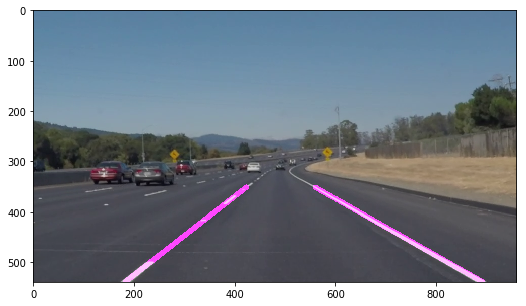

In [21]:
left_lanes = [[],[]]
right_lanes = [[],[]]
if(logger.getEffectiveLevel() < 20):#If debug is active
    white_output = F'test_videos_output/debug/{time.time()}_solidWhiteRight.mp4'
else:
    white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)
del left_lanes
del right_lanes

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [22]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

t:   0%|          | 0/681 [00:00<?, ?it/s, now=None]

Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
CPU times: user 4min 35s, sys: 9.38 s, total: 4min 44s
Wall time: 4min 44s


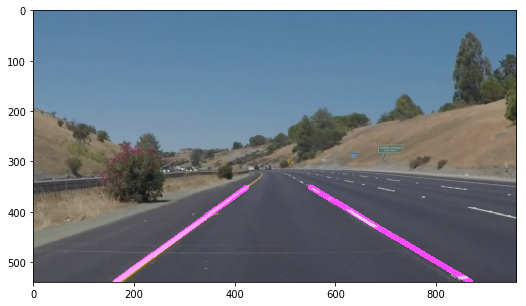

In [23]:
left_lanes = [[],[]]
right_lanes = [[],[]]
if(logger.getEffectiveLevel() < 20):#If debug is active
    yellow_output = F'test_videos_output/debug/{time.time()}_solidYellowLeft.mp4'
else:
    yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)
del left_lanes
del right_lanes

In [24]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Shadows


t:   0%|          | 0/251 [00:00<?, ?it/s, now=None]

Moviepy - Building video test_videos_output/challenge.mp4.
Moviepy - Writing video test_videos_output/challenge.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/challenge.mp4
CPU times: user 2min 2s, sys: 6.53 s, total: 2min 8s
Wall time: 2min 9s


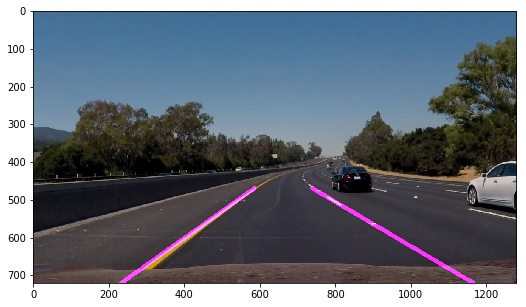

In [25]:
left_lanes = [[],[]]
right_lanes = [[],[]]
if(logger.getEffectiveLevel() < 20):#If debug is active
    challenge_output = F'test_videos_output/debug/{time.time()}_challenge.mp4'
else:
    challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)
del left_lanes
del right_lanes

In [26]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))